### Description
This notebook contains all code for the graphs used to confirm that the DO and PCT_SAT columns that change names after 2020 can be merged

In [11]:
import os
import dateparser
import pandas as pd
import matplotlib.pyplot as plt

In [12]:
data_dir = '../../data/'
new_data_dir = data_dir + 'MassBay/NewFormat/'

### Graph to validate Dissolved Oxygen and Percent Saturation Metrics across years

In [13]:
whitelist = []
# check that each excel file in the data_dir has only one sheet, add to blacklist if not
newcsvs = {}
for file in os.listdir(new_data_dir):
    if file.endswith('.xlsx'):
        all_sheets = pd.read_excel(new_data_dir + file, sheet_name=None)
        if len(all_sheets) != 1 and file not in whitelist:
            print('ERROR:', file, 'has', len(all_sheets), 'sheets')
        else:
            first_sheet = all_sheets[list(all_sheets.keys())[0]]
            newcsvs[file] = first_sheet

In [14]:
# Create seperate lists of data withDO_RAW  DISS_OXYGEN columns
raw = []
non_raw = []

for csv in newcsvs:
    if 'DO_RAW (mg/L)' in newcsvs[csv].columns:
        raw.append(newcsvs[csv])
    else:
        non_raw.append(newcsvs[csv])

# Seperate concatenations of DO_RAW vs DISS_OXYGEN columns
raw_df = pd.concat(raw, ignore_index = True, sort = False)
non_raw_df = pd.concat(non_raw, ignore_index = True, sort = False)

# Remove space from station col
raw_df['STAT_ID'] = [stat.strip(" ") for stat in raw_df['STAT_ID']]
non_raw_df['STAT_ID'] = [stat.strip(" ") for stat in non_raw_df['STAT_ID']]

# Get stations in common
unique_stations = list(set(raw_df['STAT_ID']).intersection(set(non_raw_df['STAT_ID'])))
all_stations = list(set(raw_df['STAT_ID']).union(set(non_raw_df['STAT_ID'])))

# Convert timestamp to datetime if string
for ind, row in non_raw_df.iterrows():
    date_str = row['PROF_DATE_TIME_LOCAL']
    if type(date_str) == str:
        non_raw_df.loc[ind, 'PROF_DATE_TIME_LOCAL'] = dateparser.parse(date_str)

# 
# Build yearly data:
y2020 = raw_df
y2021 = pd.DataFrame(columns = non_raw_df.columns)
y2022 = pd.DataFrame(columns = non_raw_df.columns)

for ind, row in non_raw_df.iterrows():
    if row['PROF_DATE_TIME_LOCAL'].strftime("%Y") == "2021":
        y2021.loc[len(y2021.index)] = row
    else:
        y2022.loc[len(y2022.index)] = row

In [15]:
# Get averge DO metric, depth for each common station between the two datasets
raw_avg = []
raw_avg_pct = []
raw_depth_avg = []

non_raw_avg = []
non_raw_avg_pct = []
non_raw_depth_avg = []

y2021_avg = []
y2021_avg_depth = []

y2022_avg = []
y2022_avg_depth = []

for station in unique_stations:
    raw_data = raw_df[raw_df['STAT_ID'] == station]
    non_raw_data = non_raw_df[non_raw_df['STAT_ID'] == station]
    y2021_data = y2021[y2021['STAT_ID'] == station]
    y2022_data = y2022[y2022['STAT_ID'] == station]
    
    raw_avg.append(raw_data['DO_RAW (mg/L)'].mean())
    raw_avg_pct.append(raw_data['PCT_SAT_RAW (PCT)'].mean())
    raw_depth_avg.append(raw_data['DEPTH (m)'].mean())
    
    non_raw_avg.append(non_raw_data['DISS_OXYGEN (mg/L)'].mean())
    non_raw_avg_pct.append(non_raw_data['PCT_SAT (PCT)'].mean())
    non_raw_depth_avg.append(non_raw_data['DEPTH (m)'].mean())
    
    y2021_avg.append(y2021_data['DISS_OXYGEN (mg/L)'].mean())
    y2021_avg_depth.append(y2021_data['DEPTH (m)'].mean())
    
    y2022_avg.append(y2022_data['DISS_OXYGEN (mg/L)'].mean())
    y2022_avg_depth.append(y2022_data['DEPTH (m)'].mean())

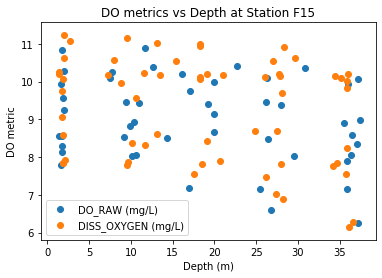

In [16]:
# At one station
raw_data_f15 = raw_df[raw_df['STAT_ID'] == 'F15']
non_raw_data_f15 = non_raw_df[non_raw_df['STAT_ID'] == 'F15']
# Temperature
plt.scatter(raw_data_f15['DEPTH (m)'], raw_data_f15['DO_RAW (mg/L)'], label = 'DO_RAW (mg/L)')
plt.scatter(non_raw_data_f15['DEPTH (m)'], non_raw_data_f15['DISS_OXYGEN (mg/L)'], label = "DISS_OXYGEN (mg/L)")
plt.xlabel("Depth (m)")
plt.ylabel("DO metric")
plt.title("DO metrics vs Depth at Station F15")
plt.legend()

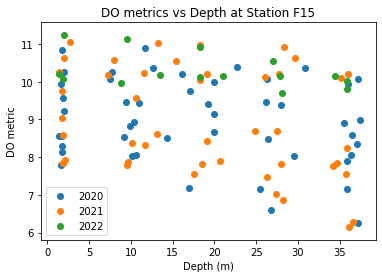

In [17]:
# At one station yearly
y2020_f15 = y2020[y2020['STAT_ID'] == 'F15']
y2021_f15 = y2021[y2021['STAT_ID'] == 'F15']
y2022_f15 = y2022[y2022['STAT_ID'] == 'F15']

plt.scatter(y2020_f15['DEPTH (m)'], y2020_f15['DO_RAW (mg/L)'], label = '2020')
plt.scatter(y2021_f15['DEPTH (m)'], y2021_f15['DISS_OXYGEN (mg/L)'], label = "2021")
plt.scatter(y2022_f15['DEPTH (m)'], y2022_f15['DISS_OXYGEN (mg/L)'], label = "2022")
plt.xlabel("Depth (m)")
plt.ylabel("DO metric")
plt.title("DO metrics vs Depth at Station F15")
plt.legend()

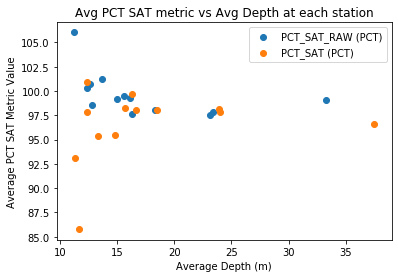

In [18]:
# Average across all common stationas
plt.scatter(raw_depth_avg, raw_avg_pct, label = 'PCT_SAT_RAW (PCT)')
plt.scatter(non_raw_depth_avg, non_raw_avg_pct, label = "PCT_SAT (PCT)")
plt.xlabel("Average Depth (m)")
plt.ylabel("Average PCT SAT Metric Value")
plt.title("Avg PCT SAT metric vs Avg Depth at each station")
plt.legend()